### Collaborative Filtering on the Book-Crossing Dataset

In [3]:
pip install surprise

     |████████████████████████████████| 11.8MB 345kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1646983 sha256=3c8f1a68e993a14a1deb985e481dfb4f1431358ed7cddea4a84039c40076c57c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [4]:
#Imported required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split as splits
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import cross_validate
pd.set_option('display.max_columns', None)
import tensorflow as tf
import pickle

## Data Exploration and Preprocessing

In [5]:
books=pd.read_csv('/content/drive/My Drive/Books Recommendation data/BX-Books.csv', sep=';', error_bad_lines=False,encoding="latin-1")
ratings=pd.read_csv('/content/drive/My Drive/Books Recommendation data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False,encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

In [6]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
ratings.shape

(1149780, 3)

In [11]:
df=pd.merge(ratings,books,on='ISBN', how='right')

As per the authors of this dataset ratings are both implicit and explicit, later is defined as 0, while explicit are in its raw form ranging from 1 to 10 

In [9]:
print('Implicit Ratings:',df[df['Book-Rating']==0].shape[0])
print('Explicit Ratings:',df[df['Book-Rating']>0].shape[0])

Implicit Ratings: 647294
Explicit Ratings: 383842


In [14]:
#before merge counts for user, ratings and interactions
print('No of Users: {}, No of Books: {}, Interactions: {}'.format(len(ratings['User-ID'].unique()),len(ratings['ISBN'].unique()),ratings.shape[0]))

No of Users: 105283, No of Books: 340556, Interactions: 1149780


In [10]:
#after merge, counts of user, ratings and interactions
print('No of Users: {}, No of Books: {}, Interactions: {}'.format(len(df['User-ID'].unique()),len(df['Book-Title'].unique()),df.shape[0]))

No of Users: 92106, No of Books: 241071, Interactions: 1031136


we lost lot of users and books after merging, certainly because we don't have titles for many books

In [14]:
def load_dataset(feedback_type):
    """
    Loads the dataset and transforms it into the format we need. 
    
    We then split it into a training,test set and the other required mappings.
    """

    # Load the data from disk
    books=pd.read_csv('/content/drive/My Drive/Books Recommendation data/BX-Books.csv', sep=';', error_bad_lines=False,encoding="latin-1").iloc[:,0:2]
    ratings=pd.read_csv('/content/drive/My Drive/Books Recommendation data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False,encoding="latin-1")

    # Add column names
    df=pd.merge(ratings,books[['ISBN','Book-Title']],on='ISBN')
    df = df.drop(['ISBN'], axis=1)
    df=df.rename(columns = {'User-ID':'user','Book-Title':'item','Book-Rating':'rating'})

    # Drop any rows with empty cells or rows
    # with a play count of zero.
    df = df.dropna()
    if feedback_type =='implicit':
      df['rating']=df['rating'] + 1
    else:
      df = df.loc[df.rating > 0]

    #drop books with less than 50 interactions
    count=df.groupby('item')['rating'].count()
    df=df[df['item'].isin(count[count>50].index)]

    # Remove any users with fewer than 1 interaction. 
    df_count = df.groupby(['user']).count()
    df['count'] = df.groupby('user')['user'].transform('count')
    df = df[df['count'] > 1]

    # Convert books into numerical IDs
    df['user_id'] = df['user'].astype("category").cat.codes
    df['item_id'] = df['item'].astype("category").cat.codes

    # Create a lookup frame so we can get the books back in readable form later.
    user_lookup=df[['user_id', 'user']].drop_duplicates()
    item_lookup = df[['item_id', 'item']].drop_duplicates()
    item_lookup['item_id'] = item_lookup.item_id.astype(str)

    # Grab the columns we need in the order we need them.
    df = df[['user_id', 'item_id', 'rating']]

    # Create training and test sets.
    df_train, df_test = train_test_split(df)

    # Create lists of all unique users and books
    users = list(np.sort(df.user_id.unique()))
    items = list(np.sort(df.item_id.unique()))

    # Get the rows, columns and values for our matrix.
    rows = df_train.user_id.astype(int)
    cols = df_train.item_id.astype(int)

    values = list(df_train.rating)

    # Get all user ids and item ids.
    uids = np.array(rows.tolist())
    iids = np.array(cols.tolist())

    # Sample 100 negative interactions for each user in our test data
    df_neg = get_negatives(uids, iids, items, df_test)

    return uids, iids, df_train, df_test,df_neg, users, items, item_lookup,user_lookup

In [15]:
def get_negatives(uids, iids, items, df_test):
    """Returns a pandas dataframe of 100 negative interactions
    based for each user in df_test.
    Args:
        uids (np.array): Numpy array of all user ids.
        iids (np.array): Numpy array of all item ids.
        items (list): List of all unique items.
        df_test (dataframe): Our test set.
    Returns:
        df_neg (dataframe): dataframe with 100 negative items 
            for each (u, i) pair in df_test.
    """

    negativeList = []
    test_u = df_test['user_id'].values.tolist()
    test_i = df_test['item_id'].values.tolist()

    test_ratings = list(zip(test_u, test_i))
    zipped = set(zip(uids, iids))

    for (u, i) in test_ratings:
        negatives = []
        negatives.append((u, i))
        for t in range(100):
            j = np.random.randint(len(items)) # Get random item id.
            while (u, j) in zipped: # Check if there is an interaction
                j = np.random.randint(len(items)) # If yes, generate a new item id
            negatives.append(j) # Once a negative interaction is found we add it.
        negativeList.append(negatives)

    df_neg = pd.DataFrame(negativeList)

    return df_neg

def mask_first(x):
    """
    Return a list of 0 for the first item and 1 for all others
    """
    result = np.ones_like(x)
    result[0] = 0
    
    return result
   
def train_test_split(df):
    """
    Splits our original data into one test and one
    training set. 
    The test set is made up of one item for each user. This is
    our holdout item used to compute Top@K later.
    The training set is the same as our original data but
    without any of the holdout items.
    Args:
        df (dataframe): Our original data
    Returns:
        df_train (dataframe): All of our data except holdout items
        df_test (dataframe): Only our holdout items.
    """

    # Create two copies of our dataframe that we can modify
    df_test = df.copy(deep=True)
    df_train = df.copy(deep=True)

    # Group by user_id and select only the first item for
    # each user (our holdout).
    df_test = df_test.groupby(['user_id']).first()
    df_test= df_test.reset_index()
    df_test = df_test[['user_id', 'item_id', 'rating']]
    #df_test.index.name

    # Remove the same items as we for our test set in our training set.
    mask = df.groupby(['user_id'])['user_id'].transform(mask_first).astype(bool)
    df_train = df.loc[mask]

    return df_train, df_test

## SVD for Explicit ratings


In [16]:
#Loading Dataset for explicit data
uids, iids, df_train, df_test,df_neg, users, items, item_lookup,user_lookup=load_dataset('explicit')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:28

In [17]:
#Surprise package requires data to be in certain format before fiting in the model
reader= Reader(rating_scale=(1, 10))
exp_train=Dataset.load_from_df(df_train, reader=reader)
exp_train=exp_train.build_full_trainset()

In [18]:
#formating test set required by surprise package
exp_test=[]
for u,i,r in zip(df_test['user_id'],df_test['item_id'],df_test['rating']):
  exp_test.append((u,i,r))

In [19]:
model_exp=SVD()
model_exp.fit(exp_train)
predictions=model_exp.test(exp_test)

In [20]:
#Rmse 
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.6671
MAE:  1.2850


1.2849733271562978

In [57]:
filename='/content/drive/My Drive/Books Recommendation data/explicit_model.sav'
pickle.dump(model_exp,open(filename, 'wb'))

In [58]:
#recommender Function
def recommendation_expl(): 
  userid=int(input('Enter UserId '))
  filename='/content/drive/My Drive/Books Recommendation data/explicit_model.sav'
  model = pickle.load(open(filename, 'rb'))
  usr=user_lookup.loc[user_lookup.user==userid,'user_id'].item() 
  neg = df_neg.drop(df_neg.columns[0], axis=1)
  test_negatives = neg.values.tolist()[usr]
  predictions=[]
  for iid in test_negatives:
    p=model.predict(userid,iid).est
    book=item_lookup.loc[(item_lookup.item_id==str(iid)),'item'].item()
    predictions.append({'item_id':iid,'Books':book,'rating':p})
  
  predictions=pd.DataFrame(predictions)
  recommend=predictions.sort_values(by=['rating'],ascending=False)['Books'].tolist()[0:5]
  image_url=books[books['Book-Title'].isin(recommend)]['Image-URL-L'].tolist()
  fig=plt.figure(figsize=(15, 15))
  columns = 5
  rows = 1

  for url,i in zip(image_url,range(1, columns*rows +1)):
    response = requests.get(url)
    img=Image.open(BytesIO(response.content))
    fig.add_subplot(rows, columns,i)
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  return print("Here's the list of Books user might like as well:"),plt.show()



Enter UserId 13279
Here's the list of Books user might like as well:


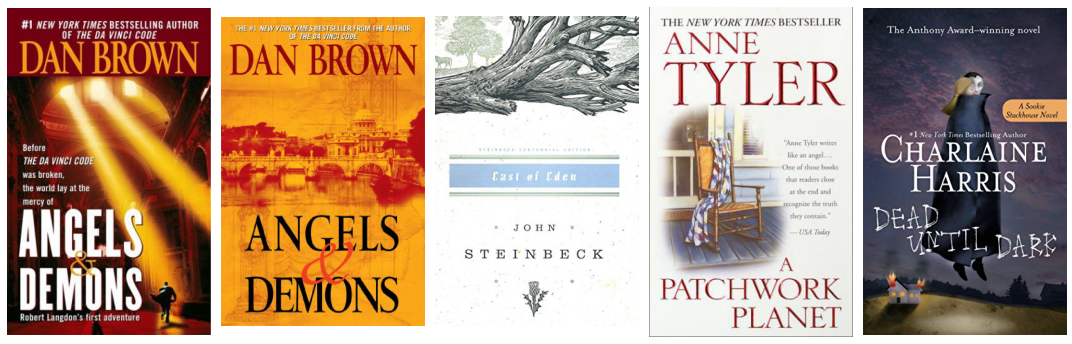

(None, None)

In [60]:
recommendation_expl()

## Neural Colaborative Filtering using both implicit and explicit ratings

In [42]:
from tensorflow.keras.layers import Embedding, Input, Dense, Reshape, Flatten
from tensorflow.keras.regularizers import l2

In [43]:
uids, iids, df_train, df_test,df_neg, users, items, item_lookup,user_lookup=load_dataset('implicit')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:28

The model, Neural Collaborative Filtering is proposed in this [Paper](https://arxiv.org/pdf/1708.05031.pdf). Lot of the working here is inspired from the code implementation on [Github](https://github.com/hexiangnan/neural_collaborative_filtering) by the authors of the paper and also this [article](https://medium.com/@victorkohler/collaborative-filtering-using-deep-neural-networks-in-tensorflow-96e5d41a39a1) by Victor. Do checkout the paper and also the article, it neatly explains the concept of NCF.

In [44]:
#Neural Network made of 4 dense layers of MLP and a layer of Matrix Factorization
#MF - Matrix Factorization , MLP - Multi Layer Perceptron
num_users=len(users)
num_items=len(items)
latent_dim=8
user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

#Embedding

MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'mf_user_embedding',
                                  embeddings_initializer= tf.random_normal_initializer(stddev=0.05, seed=None),embeddings_regularizer= tf.keras.regularizers.l2(0),
                                 input_length=1)
MF_Embedding_Item =  Embedding(input_dim = num_items, output_dim = latent_dim, name = 'mf_item_embedding',
                                  embeddings_initializer = tf.random_normal_initializer(stddev=0.05, seed=None),embeddings_regularizer = tf.keras.regularizers.l2(0),
                                 input_length=1)

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = 32, name = 'mlp_user_embedding',
                                  embeddings_initializer= tf.random_normal_initializer(stddev=0.05, seed=None), embeddings_regularizer = tf.keras.regularizers.l2(0),
                                 input_length=1)
MLP_Embedding_Item =  Embedding(input_dim = num_items, output_dim = 32, name = 'mlp_item_embedding',
                                  embeddings_initializer= tf.random_normal_initializer(stddev=0.05, seed=None), embeddings_regularizer = tf.keras.regularizers.l2(0),
                                 input_length=1)
#Flattening

mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_item_latent = Flatten()(MF_Embedding_Item(item_input))

#Dot matrix 
mf_matrix=tf.keras.layers.multiply([mf_user_latent,mf_item_latent])

mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))

mlp_concat= tf.keras.layers.concatenate([mlp_user_latent,mlp_item_latent])

x= tf.keras.layers.Dropout(0.2)(mlp_concat)
x= tf.keras.layers.Dense(64, activation='relu', name='layer1')(x)
x= tf.keras.layers.BatchNormalization(name='batch_norm1')(x)
x= tf.keras.layers.Dropout(0.2, name='dropout1')(x)
x= tf.keras.layers.Dense(32, activation='relu', name='layer2')(x)
x= tf.keras.layers.BatchNormalization(name='batch_norm2')(x)
x= tf.keras.layers.Dropout(0.2, name='dropout2')(x)
x= tf.keras.layers.Dense(16, activation='relu', name='layer3')(x)
x= tf.keras.layers.Dense(8, activation='relu', name='layer4')(x)

#Concatenation of MF and MLP
concat_layer= tf.keras.layers.concatenate([mf_matrix,x])

#final prediction layer
final_layer= tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer='lecun_uniform', name = "prediction")(concat_layer)
model_impl=tf.keras.Model([user_input,item_input],final_layer)  
  

In [45]:
def get_train_instances():
     """Samples a number of negative user-item interactions for each
     user-item pair in our testing data.
     Returns:
         user_input (list): A list of all users for each item
         item_input (list): A list of all items for every user,
             both positive and negative interactions.
         labels (list): A list of all labels. 0 or 1.
     """

     user_input, item_input, labels = [],[],[]
     zipped = set(zip(uids, iids))

     for (u, i) in zip(uids,iids):
         # Add our positive interaction
         user_input.append(u)
         item_input.append(i)
         labels.append(1)

         # Sample a number of random negative interactions
         for t in range(num_neg):
             j = np.random.randint(len(items))
             while (u, j) in zipped:
                 j = np.random.randint(len(items))
             user_input.append(u)
             item_input.append(j)
             labels.append(0)

     return user_input, item_input, labels



In [46]:
from time import time

batch_size=256
epochs=10
num_neg=4
learning_rate=0.001


model_impl.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy')

for e in range(epochs):
        t1 = time()
        # Generate training instances
        user_input, item_input, labels = get_train_instances()
        
        # Training
        hist = model_impl.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
        t2 = time()

In [47]:
import math
import heapq # for retrieval topK
import multiprocessing
import numpy as np
from time import time

test_u = df_test['user_id'].values.tolist()
test_i = df_test['item_id'].values.tolist()

test_ratings = list(zip(test_u, test_i))

df_neg = df_neg.drop(df_neg.columns[0], axis=1)
test_negatives = df_neg.values.tolist()
model=model_impl
def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
        
    hits, ndcgs = [],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        return (hits, ndcgs)
    # Single thread
    for idx in range(len(testRatings)):
        (hr,ndcg) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)      
    return (hits, ndcgs)

def eval_one_rating(idx):
    rating = test_ratings[idx]
    items = test_negatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(10, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [ ]:
(hits,NDCG)=evaluate_model(model_impl,test_ratings,test_negatives,10,1)

In [51]:
print('hitrate: ',np.array(hits).mean())
print('NDCG: ',np.array(NDCG).mean())

hitrate:  0.4766431417734889
NDCG:  0.27228277169738835


In [52]:
model_impl.save('/content/drive/My Drive/Books Recommendation data/implicit_model.h5')

In [55]:
from tensorflow.keras.models import load_model
def recommendation_impl(): 
  userid= int(input('Enter UserId '))
  model= load_model('/content/drive/My Drive/Books Recommendation data/implicit_model.h5')
  usr=user_lookup.loc[user_lookup.user==userid,'user_id'].item() 


  neg = df_neg.drop(df_neg.columns[0], axis=1)
  test_negatives = neg.values.tolist()
  items = test_negatives[usr]

  map_item_score = []
  users = np.full(len(items), usr, dtype = 'int32')
  predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
  for i in range(len(items)):
    book_item=item_lookup.loc[(item_lookup.item_id==str(i)),'item'].item()
    score=predictions[i][0]
    map_item_score.append({'Book':book_item,'Score':score})

  predictions=pd.DataFrame(map_item_score)
  recommend=predictions.sort_values(by=['Score'],ascending=False)['Book'].tolist()[0:5]
  image_url=books[books['Book-Title'].isin(recommend)]['Image-URL-L'].tolist()
  fig=plt.figure(figsize=(15, 15))
  columns = 5
  rows = 1

  for url,i in zip(image_url,range(1, columns*rows +1)):
    response = requests.get(url)
    img=Image.open(BytesIO(response.content))
    fig.add_subplot(rows, columns,i)
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  return print("Here's the list of Books user might like as well:"),plt.show()  
  
  

Enter UserId 13279
Here's the list of Books user might like as well:


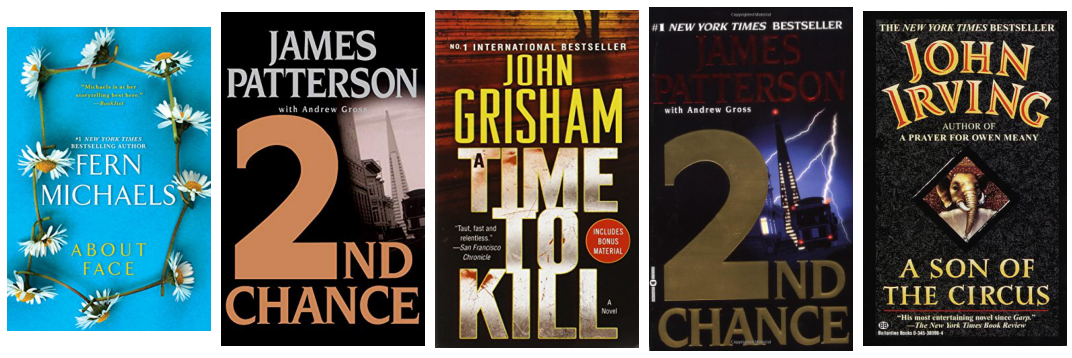

(None, None)

In [61]:
recommendation_impl()